# Elastix Logs Exploration

## Plot cost function

In [6]:
import glob
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageOps
import seaborn as sns
import SimpleITK as sitk
import time
import warnings

In [3]:
SLIDES_PATH = '/gpfs1/scratch/90days/s4436005'
os.chdir(SLIDES_PATH)
os.getcwd()

'/gpfs1/scratch/90days/s4436005'

In [41]:
LOG_PATH = os.path.join(os.getcwd(), 'elastix.log')
LOG_PATH

'/gpfs1/scratch/90days/s4436005/elastix.log'

In [42]:
f = open(LOG_PATH)
f1 = f.readlines()
is_elastix_header = lambda line:True if line[0:2] == '1:' else False
for line in f1:
    #check if line start with a number
    if line[0].isdigit() == True:
        print(line)
    pass

1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]

0	-0.449346	0.000000	4.805260	0.014405	113.5

1	-0.460763	0.000000	4.805260	0.021006	1.3

2	-0.427725	0.000000	4.805260	0.014394	1.3

3	-0.471485	0.000000	4.805260	0.022149	1.4

4	-0.439825	0.999990	4.586841	0.021444	1.2

5	-0.488341	0.365397	4.723079	0.019720	1.3

6	-0.448252	1.365396	4.511901	0.006219	1.3

7	-0.495299	1.436119	4.497679	0.010516	1.2

8	-0.497790	0.852895	4.617716	0.020455	1.3

9	-0.474736	0.221293	4.755151	0.008188	1.3

10	-0.454057	0.000000	4.805260	0.010277	1.3

11	-0.496977	0.868067	4.614512	0.016168	1.3

12	-0.449522	1.868041	4.412729	0.007247	1.2

13	-0.451375	1.233447	4.538678	0.007540	1.2

14	-0.466518	0.606145	4.670452	0.008460	1.2

15	-0.485087	1.480750	4.488750	0.009484	1.2

16	-0.450102	2.002735	4.386890	0.021867	1.2

17	-0.485095	1.368147	4.511347	0.012992	1.2

18	-0.456752	0.733553	4.643072	0.017727	1.2

19	-0.462059	0.098959	4.782722	0.012993	1.2

20	-0.481687	0.000000	4.805260	0.011919	1.2

21


336	-0.704397	-0.704481	0.000084	55.252136	2322.784547	0.002247	0.000000	0.002247	1.1	1.5	5.3

337	-0.709719	-0.709798	0.000079	56.250747	2292.758188	0.002258	0.000000	0.002258	1.2	1.5	5.3

338	-0.697238	-0.697316	0.000078	55.600068	2312.234012	0.002002	0.000000	0.002002	1.1	1.4	5.3

339	-0.676331	-0.676413	0.000082	54.937053	2332.422394	0.002044	0.000000	0.002044	1.3	1.5	5.4

340	-0.683409	-0.683490	0.000081	54.402165	2348.968131	0.002020	0.000000	0.002020	1.1	1.8	5.8

341	-0.702305	-0.702385	0.000081	55.400286	2318.280361	0.002227	0.000000	0.002227	1.2	2.2	6.1

342	-0.704116	-0.704196	0.000080	56.400227	2288.330280	0.002133	0.000000	0.002133	1.2	1.8	5.8

343	-0.688296	-0.688374	0.000077	55.737206	2308.101778	0.002092	0.000000	0.002092	1.2	1.7	5.7

344	-0.684635	-0.684716	0.000081	55.409145	2318.011578	0.002132	0.000000	0.002132	1.3	1.7	5.9

345	-0.676769	-0.676850	0.000081	54.746124	2338.301592	0.002062	0.000000	0.002062	4.7	1.3	8.6

346	-0.707943	-0.708025	0.000082	55.746110	2307.8

In [43]:
headers = []
for line in f1:
    if is_elastix_header(line):
        headers.append(line)
affine_headers = headers[0:4]
bspline_headers = headers[4:]

In [44]:
affine_headers

['1:ItNr\t2:Metric\t3a:Time\t3b:StepSize\t4:||Gradient||\tTime[ms]\n',
 '1:ItNr\t2:Metric\t3a:Time\t3b:StepSize\t4:||Gradient||\tTime[ms]\n',
 '1:ItNr\t2:Metric\t3a:Time\t3b:StepSize\t4:||Gradient||\tTime[ms]\n',
 '1:ItNr\t2:Metric\t3a:Time\t3b:StepSize\t4:||Gradient||\tTime[ms]\n']

In [45]:
affine_lines = []
affine_lines.append(affine_headers[0])
for line in f1:
    if line in bspline_headers:
        break
    elif line not in affine_headers and line[0].isdigit() == True:
         affine_lines.append(line)
            
bspline_lines = []
bspline_region = False
for line in f1:
    if line in bspline_headers and bspline_region == False:
        bspline_lines.append(line)
        bspline_region = True
    elif line not in bspline_headers and line[0].isdigit() == True and bspline_region == True:
         bspline_lines.append(line)

In [46]:
len(bspline_lines)

4097

In [47]:
f_affine = io.StringIO()
f_affine.writelines(affine_lines)

f_bspline = io.StringIO()
f_bspline.writelines(bspline_lines)

In [48]:
f_affine.seek(0)
affine_df = pd.read_csv(f_affine, delim_whitespace = True)

f_bspline.seek(0)
bspline_df = pd.read_csv(f_bspline, delim_whitespace = True)

In [49]:
affine_df.head()

,1:ItNr,2:Metric,3a:Time,3b:StepSize,4:||Gradient||,Time[ms]
0,0,-0.449346,0.00000,4.805260,0.014405,113.5
1,1,-0.460763,0.00000,4.805260,0.021006,1.3
2,2,-0.427725,0.00000,4.805260,0.014394,1.3
3,3,-0.471485,0.00000,4.805260,0.022149,1.4
4,4,-0.439825,0.99999,4.586841,0.021444,1.2


In [50]:
affine_df.describe()

,1:ItNr,2:Metric,3a:Time,3b:StepSize,4:||Gradient||,Time[ms]
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,255.500000,-0.450523,6.855188,1.773530,0.031689,1.399756
std,147.837485,0.053429,8.104619,1.581773,0.021657,2.972889
min,0.000000,-0.585269,0.000000,0.306493,0.003806,1.200000
25%,127.750000,-0.491080,1.380591,0.649945,0.015695,1.200000
50%,255.500000,-0.447215,3.757632,0.993647,0.024177,1.200000
75%,383.250000,-0.403013,8.593755,2.045136,0.042616,1.300000
max,511.000000,-0.339493,41.541569,4.805260,0.139153,113.500000


In [51]:
bspline_df.head()

,1:ItNr,2:Metric,2:Metric0,2:Metric1,3a:Time,3b:StepSize,4:||Gradient0||,4:||Gradient1||,4:||Gradient||,Time0[ms],Time1[ms],Time[ms]
0,0,-0.546352,-0.546352,0.0,0.0,11361.418176,0.001087,0.0,0.001087,1.0,2.1,114.4
1,1,-0.559562,-0.559562,0.0,0.0,11361.418176,0.001179,0.0,0.001179,1.6,2.1,6.2
2,2,-0.578114,-0.578114,0.0,0.0,11361.418176,0.001216,0.0,0.001216,1.2,2.4,6.1
3,3,-0.563389,-0.563389,0.0,0.0,11361.418176,0.001211,0.0,0.001211,1.1,1.5,5.1
4,4,-0.565436,-0.565436,0.0,0.0,11361.418176,0.001127,0.0,0.001127,1.1,1.7,5.3


In [52]:
affine_df.columns.values

array(['1:ItNr', '2:Metric', '3a:Time', '3b:StepSize', '4:||Gradient||',
       'Time[ms]'], dtype=object)

In [53]:
affine_df.index

RangeIndex(start=0, stop=2048, step=1)

The steps shows that Elastix is using different resolutions

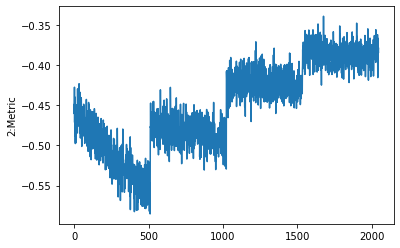

In [54]:
ax = sns.lineplot(x= affine_df.index, y='2:Metric', data = affine_df)

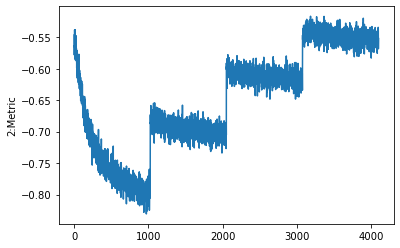

In [55]:
ax = sns.lineplot(x = bspline_df.index, y = '2:Metric', data = bspline_df)